In [1]:
# import dependencies
# import sys
# !{sys.executable} -m pip install seaborn
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import glacierml as gl
import numpy as np
import warnings
from tensorflow.python.util import deprecation
import os
import logging
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML
import geopy

# display(HTML("<style>.container { width:85% !important; }</style>"))
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
deprecation._PRINT_DEPRECATION_WARNINGS = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.set_option('display.max_columns', None)

pd.set_option('mode.chained_assignment', None)

RS = range(0,25,1)

print('currently running tensorflow version: ' + tf.__version__)

2022-07-19 10:17:35.211221: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


currently running tensorflow version: 2.9.1


In [ ]:
# select dataset to analyze

selected_dataset = 'df6'

if selected_dataset == 'df1':
    df1 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'n'
    )
    module = 'sm1'
    res = 'sr1'
    dataset = df1
    dataset.name = selected_dataset
if selected_dataset == 'df2':
    df2 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'off'
    )
    module = 'sm2'
    res = 'sr2'
    dataset = df2
    dataset.name = selected_dataset
if selected_dataset == 'df3':
    df3 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'on',
        anomaly_input = 1
    )
    module = 'sm3'
    res = 'sr3'
    dataset = df3
    dataset.name = selected_dataset
if selected_dataset == 'df4':
    df4 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'on',
        anomaly_input = 5
    )
    module = 'sm4'
    res = 'sr4'
    dataset = df4
    dataset.name = selected_dataset
if selected_dataset == 'df5':
    df5 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'off'
    )
    df5 = df5.drop('Zmed', axis = 1)
    dataset = df5
    dataset.name = selected_dataset
    module = 'sm5'
    res = 'sr5'
if selected_dataset == 'df6':
    df6 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'r',
        region_selection = 1,
        area_scrubber = 'off'
    )
    module = 'sm6'
    res = 'sr6'
    reg = df6['region'].iloc[-1]
    df6 = df6.drop('region', axis=1)
    dataset = df6 
    dataset.name = str('df6_' + str(reg))

In [ ]:
# load deviations table
rootdir = 'zults/'
predictions = pd.DataFrame()
deviations = pd.DataFrame()
for file in tqdm(os.listdir(rootdir)):
    if 'predictions' in file:
        file_reader = pd.read_csv(rootdir + file)
        predictions = predictions.append(file_reader, ignore_index = True)
    if 'deviations' in file:
        file_reader = pd.read_csv(rootdir + file)
        deviations = pd.concat([deviations, file_reader], ignore_index = True)
        
deviations = deviations.drop('Unnamed: 0', axis = 1)
predictions = predictions.drop('Unnamed: 0', axis = 1)
deviations['total parameters'] = deviations['total parameters'].astype(int)
deviations['trained parameters'] = deviations['trained parameters'].astype(int)
deviations['total inputs'] = deviations['total inputs'].astype(int)
deviations = deviations[
    (deviations['df'].str.contains('df')) 
#     &
#     (deviations['layer architecture'] == '24-12')
#     &
#     (deviations['learning rate'] == 0.010)
#     &
#     (deviations['epochs'] == 100)
]
deviations['test - train'] = (
    abs(deviations['test mae avg'] - deviations['train mae avg'])
)
deviations = deviations.sort_values(
    [
#         'test - train',
        'test mae avg', 
#         'test predicted thickness std dev'
#         'layer architecture',
#         'learning rate',
        'df'
    ]
)
deviations

In [ ]:
# calculate model parameters 
total_inputs = (len(dataset) * (len(dataset.columns) -1))
print('total inputs = ' + str(total_inputs))

non_trainable_parameters = (len(dataset.columns)) + ((len(dataset.columns) - 1))
print('non-trainable parameters = ' + str(non_trainable_parameters))

layer_1 = 50
layer_2 = 25

total_parameters = (
    layer_1 * (inputs + 1)  + 
    (layer_2 * (layer_1 + 1)) + 
    ((1 * (layer_2 + 1))) +
    non_trainable_parameters
)
print('trainable parameters = ' + str(total_parameters - non_trainable_parameters))

In [ ]:
# load selected model and look at predicted accuracies of each random state
print('Please select index from deviations table to inspect further')

selection = int(input())

arch = deviations['layer architecture'].loc[selection]
top_learning_rate = deviations['learning rate'].loc[selection]
epochs = deviations['epochs'].loc[selection]
dropout = deviations['dropout'].loc[selection]
print(arch)
print(top_learning_rate)
print(epochs)
print(dropout)

dnn_model = {}
rootdir = 'saved_models/' + module + '/sm_' + arch + '/'


train_features, test_features, train_labels, test_labels = gl.data_splitter(dataset)
features = pd.concat([train_features, test_features], ignore_index = True)
labels = pd.concat([train_labels, test_labels], ignore_index = True)
for rs in tqdm(RS):
    
    model_name = (
        str(arch) + 
        '_' + 
        dataset.name +
        '_' + 
        str(dropout) +
        '_dnn_MULTI_' + 
        str(top_learning_rate) + 
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )   
    
    model_path = (
        rootdir + 
        dataset.name +
        '_' + 
        str(dropout) +
        '_dnn_MULTI_' + 
        str(top_learning_rate) + 
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    
    dnn_model[model_name] = tf.keras.models.load_model(model_path)
    
    
    y = dnn_model[model_name].predict(features, verbose = 0)
    fig,ax=plt.subplots(1,1,figsize=(15,10))
    fig.patch.set_facecolor('w')
    plt.plot(labels,y,'.')
    plt.plot((0,400),(0,400),'-')
    plt.xlabel('True Thickness (m)')
    plt.ylabel('Model Thickness (m)')
    ax.set_title('Random State ' +str(rs))
    plt.xlim((0,400))
    plt.ylim((0,400))

In [ ]:
# load selected model loss curves

fig_dir = (
    'figs/' + 
    module + 
    '/'   
) 
isdir = os.path.isdir(fig_dir)
if isdir == False:
    os.makedirs(fig_dir)

print(arch)
print(top_learning_rate)
print(epochs)
print(dropout)

print(fig_dir)
rootdir = 'saved_results/' + res + '/sr_' + arch + '/'
print(rootdir)
dnn_history = {}
for rs in RS: 
    
    history_name = (
        arch + 
        '_' +
        dataset.name +
        '_' +
        str(dropout) +
        '_dnn_history_MULTI_' +
        str(top_learning_rate) +
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    
    model_name = (
        dataset.name +
        '_' +
        str(dropout) +
        '_dnn_history_MULTI_' +
        str(top_learning_rate) +
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    
    dnn_history[model_name] = pd.read_csv(rootdir + model_name)

    fig,ax=plt.subplots(1,1,figsize=(10,10))
    fig.patch.set_facecolor('w')
    ax.set_title(history_name)
    gl.plot_loss(dnn_history[model_name])
    
file_name = (
    fig_dir +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) + '_' +
    str(rs) + '_' +
    '.eps'
)

print(file_name)
fig.savefig(file_name)

In [2]:
# load prethicktions
tau = 100e3
rho = 1e3
g = 10

root_dir = 'zults/'
RGI_predicted = pd.DataFrame()

# read each prediction file and do stuff to it and append it to a table
for file in tqdm(os.listdir(root_dir)):
    
    if 'RGI_predicted' in file:
        file_reader = pd.read_csv(root_dir + file)
        file_reader['volume'] = (
            file_reader['avg predicted thickness'] / 1e3
        ) * file_reader['Area']
        
        # have to turn something into a series and append it to the df to build it
        sum_volume = sum(file_reader['volume'])
        total_volume = pd.Series(sum_volume, name = 'total volume')
        RGI_predicted = pd.concat([RGI_predicted, total_volume], ignore_index = True)
        
        # stick RGI attribute means into df
        if 'df1' not in file:
            mean_aspect = file_reader['Aspect'].mean()
            RGI_predicted.loc[
                RGI_predicted.index[-1], 'Aspect_RGI_mean'
            ] = mean_aspect

            mean_lmax = file_reader['Lmax'].mean()
            RGI_predicted.loc[
                RGI_predicted.index[-1], 'Lmax_RGI_mean'
            ] = mean_lmax

            mean_area = file_reader['Area'].mean()
            RGI_predicted.loc[
                RGI_predicted.index[-1], 'Area_RGI_mean'
            ] = mean_area

            mean_slope = file_reader['Slope'].mean()
            RGI_predicted.loc[
                RGI_predicted.index[-1], 'Slope_RGI_mean'
            ] = mean_slope

            mean_elev_max = file_reader['Zmax'].mean()
            RGI_predicted.loc[
                RGI_predicted.index[-1], 'Zmax_RGI_mean'
            ] = mean_elev_max

            mean_elev_min = file_reader['Zmin'].mean()
            RGI_predicted.loc[
                RGI_predicted.index[-1], 'Zmin_RGI_mean'
            ] = mean_elev_min
        
        
        # variance
        file_reader['variance'] = file_reader['predicted thickness std dev'] **2 
        variance = sum(file_reader['variance'])
        RGI_predicted.loc[
            RGI_predicted.index[-1], 'total variance'
        ] = np.sqrt(variance)/1e3

        # mean thickness
        thickness_mean = file_reader['avg predicted thickness'].mean()
        RGI_predicted.loc[
            RGI_predicted.index[-1], 'mean thickness'
        ] = thickness_mean/1e3
        
#         # max thickness
#         thickness_max = file_reader['avg predicted thickness'].max()
#         RGI_predicted.loc[
#             RGI_predicted.index[-1], 'max model thickness (km)'
#         ] = thickness_max/1e3
        
        # area * mean thickness
        area = sum(file_reader['Area'])
        RGI_predicted.loc[
            RGI_predicted.index[-1], 'vol'
        ] = (area * (thickness_mean/1e3))/1e3
        
        RGI_predicted.loc[
            RGI_predicted.index[-1], 'area'
        ] = area

            
        if 'df1' in file:
            RGI_predicted.loc[
                RGI_predicted.index[-1], 'dataframe'
            ] = 'df1'
            
            
            RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
            ] = 158.17

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'tolerance'
            ] = 41.0

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'h mean f'
            ] = 224
            if '10-5' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '10-5'
            if '16-8' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '16-8'
            if '24-12' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '24-12'
        if 'df2' in file:
            RGI_predicted.loc[
                RGI_predicted.index[-1], 'dataframe'
            ] = 'df2'   
            
            RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
            ] = 158.17

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'tolerance'
            ] = 41.0

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'h mean f'
            ] = 224

            if '10-5' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '10-5'
            if '50-28' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '50-28'
            if '64-48' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '64-48'
        if 'df3' in file:
            RGI_predicted.loc[
                RGI_predicted.index[-1], 'dataframe'
            ] = 'df3'        
             
            
            RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
            ] = 158.17

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'tolerance'
            ] = 41.0

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'h mean f'
            ] = 224
            if '10-5' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '10-5'
            if '37-20' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '37-20'
            if '59-28' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '59-28'
        if 'df4' in file:
            RGI_predicted.loc[
                RGI_predicted.index[-1], 'dataframe'
            ] = 'df4'    
             
            
            RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
            ] = 158.17

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'tolerance'
            ] = 41.0

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'h mean f'
            ] = 224
            if '10-5' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '10-5'
                
            if '47-21' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '47-21'
                
            if '64-36' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '64-36'
        if 'df5' in file:
            RGI_predicted.loc[
                RGI_predicted.index[-1], 'dataframe'
            ] = 'df5'    
             
            
            RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
            ] = 158.17

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'tolerance'
            ] = 41.0

            RGI_predicted.loc[
                RGI_predicted.index[-1], 'h mean f'
            ] = 224
            if '10-5' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '10-5'
                
            if '50-25' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '50-25'
                
            if '64-42' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '64-42'
        if 'df6' in file:
            if 'df6_01' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_01'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 18.98
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 4.92
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 218
                
            if 'df6_02' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_02'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 1.06
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.27
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 72
                
            if 'df6_03' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_03'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 28.33
            
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 7.35
            
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 270
                
            if 'df6_04' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_04'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 8.61
            
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 2.23
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 210
                
            if 'df6_05' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_05'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 15.69
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 4.07
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 175
                
            if 'df6_06' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_06'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] =  3.77
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] =  0.98 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] =  341 
                
            if 'df6_07' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_07'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] =  7.47 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] =  1.94 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] =  220 
                
            if 'df6_08' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_08'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] =  0.30 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] =  0.08 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] =  101 
                
            if 'df6_09' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_09'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 14.64
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 3.80
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 283
                
            if 'df6_10' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_10'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.14
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.04
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 56
                
            if 'df6_11' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_11'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.13
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.03
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 61
                
            if 'df6_12' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_12'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.06
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.02
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 48
                
            if 'df6_13' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_13'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 3.27
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.85
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 66
                
            if 'df6_14' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_14'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 2.87
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.74
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 85
                
            if 'df6_15' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_15'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.88
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.23
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 59
                
            if 'df6_16' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_16'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.10
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.03
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 42
                
            if 'df6_17' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_17'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 5.34
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 1.39
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 181
                
            if 'df6_18' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_18'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.07
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.02
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 63
                
            if 'df6_19' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df6_19'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 46.47
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 12.06
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 349
                
                
            if '10-5' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '10-5'
        if 'df7' in file:

            if 'df7_01' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_01'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 18.98
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 4.92
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 218
                
            if 'df7_02' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_02'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 1.06
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.27
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 72
                
            if 'df7_03' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_03'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 28.33
            
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 7.35
            
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 270
                
            if 'df7_04' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_04'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 8.61
            
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 2.23
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 210
                
            if 'df7_05' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_05'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 15.69
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 4.07
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 175
                
            if 'df7_06' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_06'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] =  3.77
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] =  0.98 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] =  341 
                
            if 'df7_07' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_07'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] =  7.47 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] =  1.94 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] =  220 
                
            if 'df7_08' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_08'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] =  0.30 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] =  0.08 
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] =  101 
                
            if 'df7_09' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_09'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 14.64
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 3.80
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 283
                
            if 'df7_10' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_10'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.14
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.04
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 56
                
            if 'df7_11' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_11'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.13
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.03
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 61
                
            if 'df7_12' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_12'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.06
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.02
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 48
                
            if 'df7_13' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_13'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 3.27
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.85
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 66
                
            if 'df7_14' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_14'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 2.87
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.74
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 85
                
            if 'df7_15' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_15'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.88
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.23
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 59
                
            if 'df7_16' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_16'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.10
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.03
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 42
                
            if 'df7_17' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_17'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 5.34
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 1.39
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 181
                
            if 'df7_18' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_18'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 0.07
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 0.02
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 63
                
            if 'df7_19' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'dataframe'
                ] = 'df7_19'
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'volf'
                ] = 46.47
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'tolerance'
                ] = 12.06
                
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'h mean f'
                ] = 349
                
            if '10-5' in file:
                RGI_predicted.loc[
                    RGI_predicted.index[-1], 'architecture'
                ] = '10-5'
                
        if '0.1' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'learning rate']= '0.100'
        if '0.01' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'learning rate']= '0.010'
        if '0.001' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'learning rate']= '0.001'
            
        if '_20' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'epochs']= '20'
        if '_25' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'epochs']= '25'
        if '_50' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'epochs']= '50'
        if '_60' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'epochs']= '60'
        if '_15' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'epochs']= '15'
        if '_30' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'epochs']= '30'
        if '_40' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'epochs']= '40'
        if '_100' in file:
            RGI_predicted.loc[RGI_predicted.index[-1], 'epochs']= '100'

RGI_predicted = RGI_predicted.drop(0, axis=1)

RGI_predicted = RGI_predicted[
    (RGI_predicted['dataframe'].str.contains('df7')) 
#     &
#     (RGI_predicted['layer architecture'] == '24-12')
#     &
#     (RGI_predicted['learning rate'] == 0.010)
#     &
#     (RGI_predicted['epochs'] == 100)
]

RGI_predicted['mean thickness'] = RGI_predicted['mean thickness'] * 1e3
RGI_predicted['voldiff'] = RGI_predicted['vol'] - RGI_predicted['volf'] 


RGI_predicted = RGI_predicted.sort_values([
#     'mean thickness (km)',
#     'architecture',
#     'learning rate',
    'dataframe'
], ascending = True)

RGI_predicted = RGI_predicted[
    RGI_predicted['vol'] < 300
]
RGI = RGI_predicted.copy()
df = RGI.copy()

100%|██████████| 123/123 [00:04<00:00, 25.09it/s]


In [ ]:
# regions that predictions line up with farinotti estimates
df = RGI_predicted.copy()
df.tolerance.astype(float)
df = pd.concat(
    [
        df[df.voldiff.between(0, df.tolerance)],
        df[df.voldiff.between(-df.tolerance, 0)]
    ], ignore_index = True
)
df

In [3]:
# compare RGI regional attributes with RGI regions matched with GlaThiDa thicknesses

dfa = pd.DataFrame()
pth_3 = '/data/fast1/glacierml/data/regional_data/raw/'
for file in tqdm(os.listdir(pth_3)):
    dfb = pd.read_csv(pth_3 + file, encoding_errors = 'replace', on_bad_lines = 'skip')
    region_and_number = file[:-4]
    region_number = region_and_number[:2]
    region = region_and_number[3:]

    dfb['geographic region'] = region
    dfb['region'] = region_number
    dfa = dfa.append(dfb, ignore_index=True)

dfa = dfa.reset_index()

dfa = dfa[[
    'GlaThiDa_index',
    'RGI_index',
    'RGIId',
    'region',
    'geographic region'
]]

pth = '/data/fast1/glacierml/data/RGI/rgi60-attribs/'
pth_2 = '/data/fast1/glacierml/data/regional_data/training_data/'
RGI_extra = pd.DataFrame()
for file in os.listdir(pth):
    f = pd.read_csv(pth + file, encoding_errors = 'replace', on_bad_lines = 'skip')
    RGI_extra = pd.concat([RGI_extra, f], ignore_index = True)

    region_and_number = file[:-4]
    region_number = region_and_number[:2]
    region = region_and_number[9:]
    dfc = dfa[dfa['region'] == region_number]
    
    for file in os.listdir(pth_2):
        if file[:2] == region_number:
            glathida_regional = pd.read_csv(pth_2 + file)

    GlaThiDa_mean_area = glathida_regional['Area'].mean()
    GlaThiDa_mean_aspect = glathida_regional['Aspect'].mean()
    GlaThiDa_mean_lmax = glathida_regional['Lmax'].mean()
    GlaThiDa_mean_slope = glathida_regional['Slope'].mean()
    GlaThiDa_mean_zmin = glathida_regional['Zmin'].mean()
    GlaThiDa_mean_zmax = glathida_regional['Zmax'].mean()
    
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Area_GlaThiDa_mean'
    ] = GlaThiDa_mean_area
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Aspect_GlaThiDa_mean'
    ] = GlaThiDa_mean_aspect
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Lmax_GlaThiDa_mean'
    ] = GlaThiDa_mean_lmax
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Slope_GlaThiDa_mean'
    ] = GlaThiDa_mean_slope
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Zmin_GlaThiDa_mean'
    ] = GlaThiDa_mean_zmin
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'Zmax_GlaThiDa_mean'
    ] = GlaThiDa_mean_zmax
    
    #     print(dfc)
    trainable_ratio = (len(dfc) / len(f))
    percent_trainable = trainable_ratio * 100
    
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'ratio trainable'
    ] = trainable_ratio
    
    df.loc[
        df[df['dataframe'].str[4:] == region_number].index, 'ratio trainable'
    ] = trainable_ratio
#     print(df['dataframe'].str[4:][df['dataframe'].str[4:] == region_number])   
    
#     if reg == region_number:
        
#         print(df['dataframe'])
#     index = df[df['dataframe'][3:] == region_number].index
#     df['dataframe'].loc[index]
#     print(df['dataframe'].loc[index])
    
    print(
        'region ' + str(region_number) + ' has ' + str(len(f)) + ' lines of data, ' +
        str(len(dfc)) + ' or ' + str(percent_trainable) +
        '% of which are trainable with GlaThiDa thicknesses'    
    )

100%|██████████| 15/15 [00:00<00:00, 271.13it/s]


region 01 has 27108 lines of data, 8 or 0.029511583296443857% of which are trainable with GlaThiDa thicknesses
region 02 has 18855 lines of data, 32 or 0.16971625563511006% of which are trainable with GlaThiDa thicknesses
region 03 has 4556 lines of data, 3 or 0.06584723441615452% of which are trainable with GlaThiDa thicknesses
region 04 has 7415 lines of data, 2 or 0.026972353337828728% of which are trainable with GlaThiDa thicknesses
region 05 has 20261 lines of data, 1 or 0.004935590543408519% of which are trainable with GlaThiDa thicknesses
region 06 has 568 lines of data, 3 or 0.528169014084507% of which are trainable with GlaThiDa thicknesses
region 07 has 1615 lines of data, 61 or 3.777089783281734% of which are trainable with GlaThiDa thicknesses
region 08 has 3417 lines of data, 6 or 0.17559262510974538% of which are trainable with GlaThiDa thicknesses
region 09 has 1069 lines of data, 12 or 1.1225444340505144% of which are trainable with GlaThiDa thicknesses
region 10 has 51

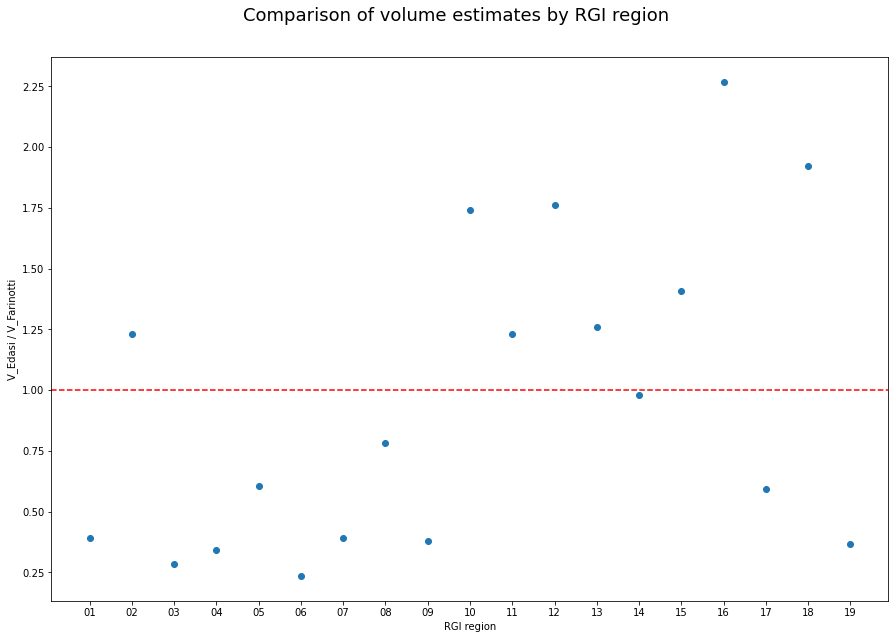

In [21]:
# volume comparisons by RGI region
dfq = df[[
    'dataframe',
    'vol',
    'volf',
    'ratio trainable'
]]
ratio = dfq.vol / dfq.volf

fig, ax = plt.subplots(1,1,figsize = (15,10))
fig.patch.set_facecolor('w')
plt.axhline(y = 1.00, color = 'red', linestyle = '--')
plt.suptitle('Comparison of volume estimates by RGI region', fontsize=18, y=0.95)
ax.set(ylabel = 'V_Edasi / V_Farinotti', xlabel = 'RGI region')
plt.scatter(x = dfq['dataframe'].str[4:], y = ratio)

# for i in dfq['dataframe'].index:
#     plt.text(
#         x = dfq['ratio trainable'].loc[i],
#         y = (
#                 dfq['vol'] / dfq['volf'].loc[i]
#             ) + 0.02,
#         s = dfq['dataframe'].str[4:].loc[i]
#     )
fig.savefig('figs/Vcomparison_region.png')
fig.savefig('figs/Vcomparison_region.eps')

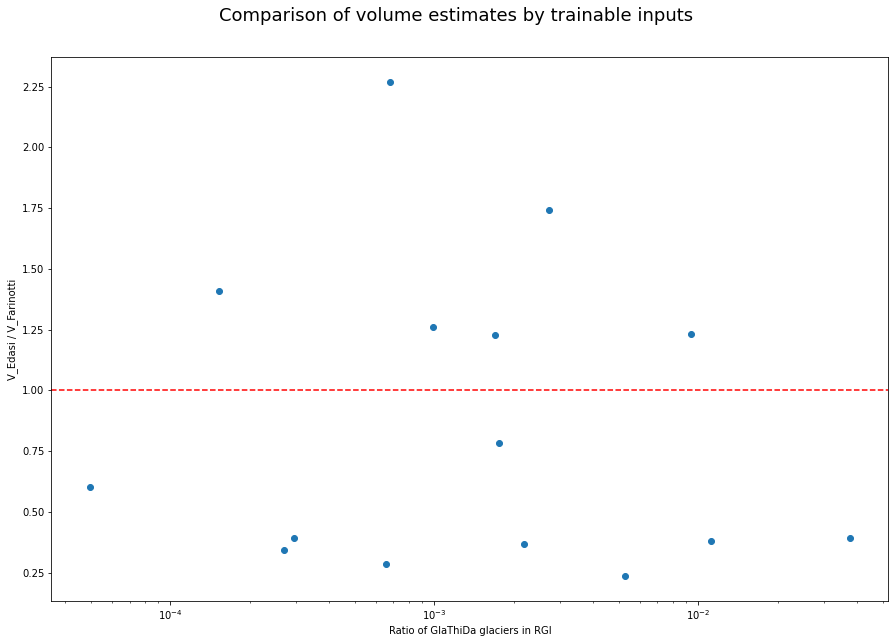

In [20]:
# volume estimates by region and trainable inputs

dfq = df[[
    'dataframe',
    'vol',
    'volf',
    'ratio trainable'
]]
ratio = dfq.vol / dfq.volf

fig, ax = plt.subplots(1,1,figsize = (15,10))
fig.patch.set_facecolor('w')
plt.axhline(y = 1.00, color = 'red', linestyle = '--')
plt.suptitle('Comparison of volume estimates by trainable inputs', fontsize=18, y=0.95)
ax.set(ylabel = 'V_Edasi / V_Farinotti', xlabel = 'Ratio of GlaThiDa glaciers in RGI')
plt.scatter(x = dfq['ratio trainable'], y = ratio)

# for i in dfq['dataframe'].index:
#     plt.text(
#         x = dfq['ratio trainable'].loc[i],
#         y = (
#             dfq['vol'] / dfq['volf'].loc[i]
#         ) + 0.02,
#         s = df['dataframe'].str[4:].loc[i]
#     )
plt.semilogx()

fig.savefig('figs/Vcomparison_trainable.png')
fig.savefig('figs/Vcomparison_trainable.eps')

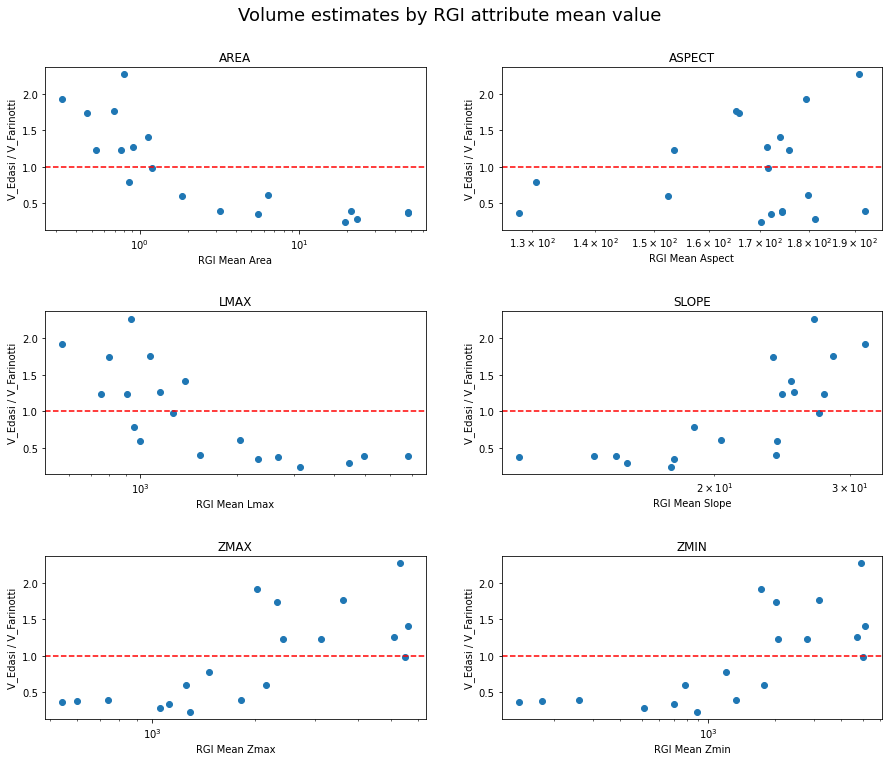

In [19]:
# volume estimates against RGI mean value for each attribute

dfs = df[[
    'vol',
    'volf'
]]
dfr = df[[
    'Area_RGI_mean',
    'Aspect_RGI_mean',
    'Lmax_RGI_mean',
    'Slope_RGI_mean',
    'Zmax_RGI_mean',
    'Zmin_RGI_mean'
]]
ratio = dfs.vol / dfs.volf

fig = plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Volume estimates by RGI attribute mean value', fontsize=18, y=0.95)
fig.patch.set_facecolor('w')
# fig.patch.set_facecolor('w')
# loop through the length of tickers and keep track of index
for n, col in enumerate(dfr.columns):
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, n + 1)
#     fig = plt.figure()
    # filter df and plot ticker on the new subplot axis
    dfr[dfr[col] == col].plot(ax=ax)
    plt.scatter(x = dfr[col], y = ratio)
    
    plt.axhline(y = 1.00, color = 'red', linestyle = '--')
    
    # chart formatting
    ax.set_title(col[:-9].upper())
    ax.get_legend().remove()
    ax.set_xlabel('RGI Mean ' + col[:-9])
    ax.set_ylabel('V_Edasi / V_Farinotti')
    plt.xscale('log')

fig.savefig('figs/Vcomparison_RGI_attribute.png')
fig.savefig('figs/Vcomparison_RGI_attribute.eps')

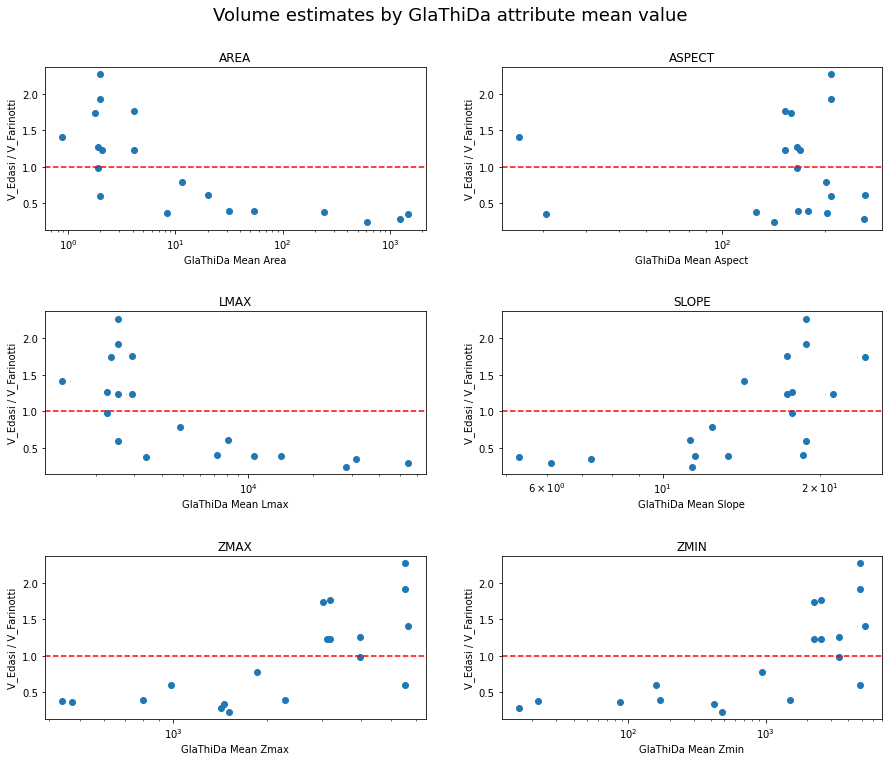

In [18]:
# volume estimates against GlaThiDa mean value for each attribute

dfs = df[[
    'vol',
    'volf'
]]
dfr = df[[
    'Area_GlaThiDa_mean',
    'Aspect_GlaThiDa_mean',
    'Lmax_GlaThiDa_mean',
    'Slope_GlaThiDa_mean',
    'Zmax_GlaThiDa_mean',
    'Zmin_GlaThiDa_mean'
]]
ratio = dfs.vol / dfs.volf

fig = plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Volume estimates by GlaThiDa attribute mean value', fontsize=18, y=0.95)
fig.patch.set_facecolor('w')
# fig.patch.set_facecolor('w')
# loop through the length of tickers and keep track of index
for n, col in enumerate(dfr.columns):
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, n + 1)
#     fig = plt.figure()
    # filter df and plot ticker on the new subplot axis
    dfr[dfr[col] == col].plot(ax=ax)
    plt.scatter(x = dfr[col], y = ratio)
    
    plt.axhline(y = 1.00, color = 'red', linestyle = '--')
    
    # chart formatting
    ax.set_title(col[:-14].upper())
    ax.get_legend().remove()
    ax.set_xlabel('GlaThiDa Mean ' + col[:-14])
    ax.set_ylabel('V_Edasi / V_Farinotti')
    plt.xscale('log')
fig.savefig('figs/Vcomparison_GlaThiDa_attribute.png')
fig.savefig('figs/Vcomparison_GlaThiDa_attribute.eps')

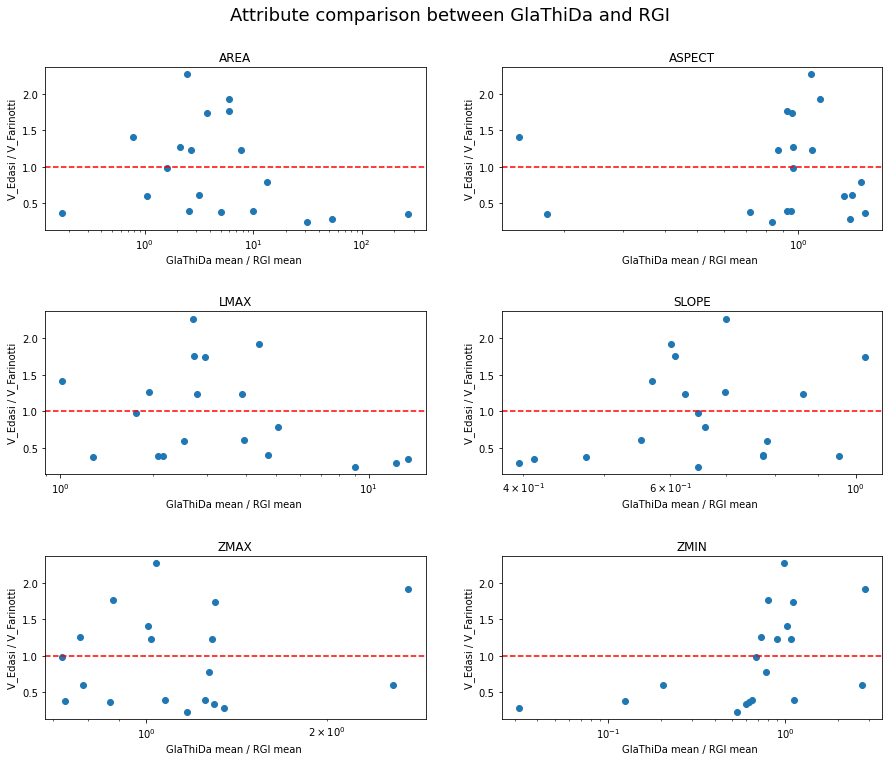

In [17]:
# volume estimates against ratio of trainable glaciers by region

dfs = df[[
    'vol',
    'volf'
]]
dfr = df[[
    'Area_RGI_mean',
    'Aspect_RGI_mean',
    'Lmax_RGI_mean',
    'Slope_RGI_mean',
    'Zmax_RGI_mean',
    'Zmin_RGI_mean'
]]
dfr = dfr.rename(columns = {
    'Area_RGI_mean':'Area',
    'Aspect_RGI_mean':'Aspect',
    'Lmax_RGI_mean':'Lmax',
    'Slope_RGI_mean':'Slope',
    'Zmax_RGI_mean':'Zmax',
    'Zmin_RGI_mean':'Zmin'
})

dfg = df[[
    'Area_GlaThiDa_mean',
    'Aspect_GlaThiDa_mean',
    'Lmax_GlaThiDa_mean',
    'Slope_GlaThiDa_mean',
    'Zmax_GlaThiDa_mean',
    'Zmin_GlaThiDa_mean'
]]
dfg = dfg.rename(columns = {
    'Area_GlaThiDa_mean':'Area',
    'Aspect_GlaThiDa_mean':'Aspect',
    'Lmax_GlaThiDa_mean':'Lmax',
    'Slope_GlaThiDa_mean':'Slope',
    'Zmax_GlaThiDa_mean':'Zmax',
    'Zmin_GlaThiDa_mean':'Zmin'
})
ratio = dfs.vol / dfs.volf



fig = plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Attribute comparison between GlaThiDa and RGI', fontsize=18, y=0.95)
fig.patch.set_facecolor('w')
# fig.patch.set_facecolor('w')
# loop through the length of tickers and keep track of index
for n, col in enumerate(dfr.columns):
#     print(list(dfg.columns.str[:-14]))
    if col in list(dfg.columns):
        
        
    # add a new subplot iteratively
        ax = plt.subplot(3, 2, n + 1)
        dfr[dfr[col] == col].plot(ax=ax)
        plt.scatter(x = dfg[col] / dfr[col], y = ratio)

        plt.axhline(y = 1.00, color = 'red', linestyle = '--')

        # chart formatting
        ax.set_title(col.upper())
        ax.get_legend().remove()
        ax.set_xlabel('GlaThiDa mean / RGI mean ')
        ax.set_ylabel('V_Edasi / V_Farinotti')
        plt.xscale('log')

#         plt.semilogx()
fig.savefig('figs/Vcomparison_GandR_attribute.png')
fig.savefig('figs/Vcomparison_GandR_attribute.eps')

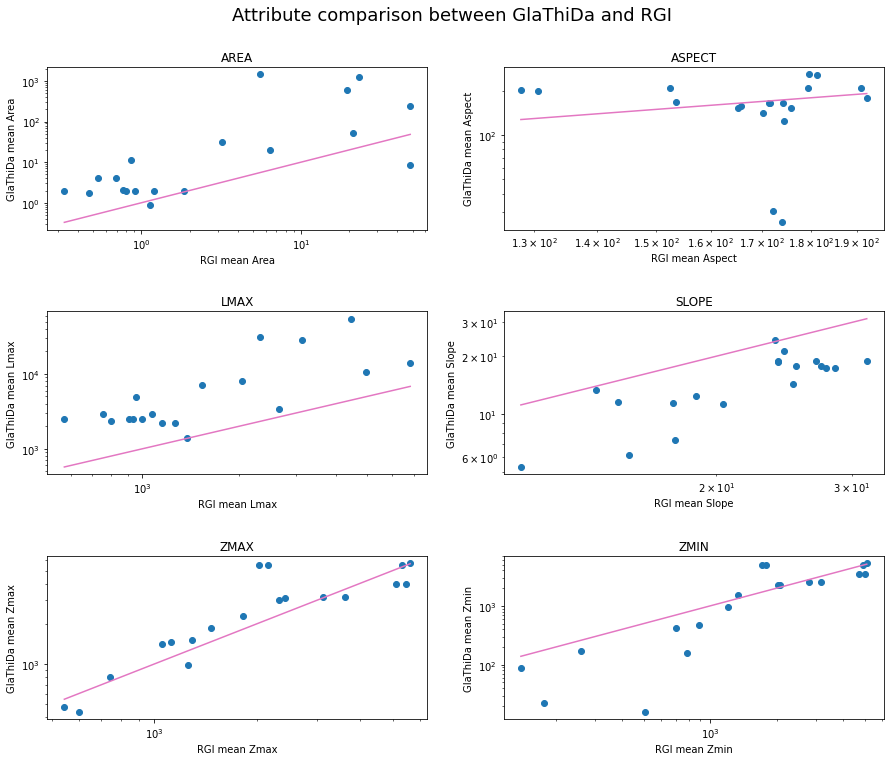

In [16]:
# GlaThiDa mean against RGI mean by region

dfs = df[[
    'vol',
    'volf'
]]
dfr = df[[
    'Area_RGI_mean',
    'Aspect_RGI_mean',
    'Lmax_RGI_mean',
    'Slope_RGI_mean',
    'Zmax_RGI_mean',
    'Zmin_RGI_mean'
]]
dfr = dfr.rename(columns = {
    'Area_RGI_mean':'Area',
    'Aspect_RGI_mean':'Aspect',
    'Lmax_RGI_mean':'Lmax',
    'Slope_RGI_mean':'Slope',
    'Zmax_RGI_mean':'Zmax',
    'Zmin_RGI_mean':'Zmin'
})

dfg = df[[
    'Area_GlaThiDa_mean',
    'Aspect_GlaThiDa_mean',
    'Lmax_GlaThiDa_mean',
    'Slope_GlaThiDa_mean',
    'Zmax_GlaThiDa_mean',
    'Zmin_GlaThiDa_mean'
]]
dfg = dfg.rename(columns = {
    'Area_GlaThiDa_mean':'Area',
    'Aspect_GlaThiDa_mean':'Aspect',
    'Lmax_GlaThiDa_mean':'Lmax',
    'Slope_GlaThiDa_mean':'Slope',
    'Zmax_GlaThiDa_mean':'Zmax',
    'Zmin_GlaThiDa_mean':'Zmin'
})
ratio = dfs.vol / dfs.volf

# Area = dfr['Area_GlaThiDa_mean'] / dfr['Area_RGI_mean']
# Aspect = dfr['Aspect_GlaThiDa_mean'] / dfr['Aspect_RGI_mean']
# Lmax = dfr['Lmax_GlaThiDa_mean'] / dfr['Lmax_RGI_mean']
# Slope = dfr['Slope_GlaThiDa_mean'] / dfr['Slope_RGI_mean']
# Zmax = dfr['Zmax_GlaThiDa_mean'] / dfr['Zmax_RGI_mean']
# Zmin = dfr['Zmin_GlaThiDa_mean'] / dfr['Zmin_RGI_mean']


fig = plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Attribute comparison between GlaThiDa and RGI', fontsize=18, y=0.95)
fig.patch.set_facecolor('w')
# fig.patch.set_facecolor('w')
# loop through the length of tickers and keep track of index
for n, col in enumerate(dfr.columns):
#     print(list(dfg.columns.str[:-14]))
    if col in list(dfg.columns):
        
        
    # add a new subplot iteratively
        ax = plt.subplot(3, 2, n + 1)
        dfr[dfr[col] == col].plot(ax=ax)
        plt.scatter(x = dfr[col], y = dfg[col])

#         plt.axhline(y = 1.00, color = 'red', linestyle = '--')
        plt.plot(
            (dfr[col].min(), dfr[col].max()),
            (dfr[col].min(), dfr[col].max()),
            '-'
        )
        # chart formatting
        ax.set_title(col.upper())
        ax.get_legend().remove()
        ax.set_xlabel('RGI mean ' + col)
        ax.set_ylabel('GlaThiDa mean ' + col)
        plt.xscale('log')
        plt.yscale('log')
fig.savefig('figs/GlaThiDa_RGI_attribute.png')
fig.savefig('figs/GlaThiDa_RGI_attribute.eps')

In [ ]:
ccccombo_breaker()
# past this point is under construction. 
# here be monsters

In [ ]:
# sns density plot
sns.set(rc={"figure.figsize":(15,10)})
sns.kdeplot(x = test_labels, y = y.flatten(),fill = True)
plt.plot((0,300),(0,300),'-')

In [ ]:
df1 = gl.RGI_loader(region_selection = 3)
print(len(df1))
df1.mean()

In [ ]:
df7 = gl.data_loader(scale = 'r', region_selection = 3)
df7.mean()

In [ ]:
df

In [ ]:
    fig,ax=plt.subplots(1,1,figsize=(15,10))
    fig.patch.set_facecolor('w')
    plt.plot(labels,y,'.')
    plt.plot((0,400),(0,400),'-')
    plt.xlabel('True Thickness (m)')
    plt.ylabel('Model Thickness (m)')
    ax.set_title('Random State ' +str(rs))
    plt.xlim((0,400))
    plt.ylim((0,400))

In [ ]:
df = RGI.copy()

In [ ]:
# not enough data to verify physical models from just data perspective